#  Dstl Satellite Imagery Feature Detection: 2

### Loading Libraries

In [3]:
!pip install tifffile

In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from collections import defaultdict
import tifffile as tif
from importlib import reload
import gc, os, inspect, glob

from shapely import wkt
from shapely import affinity
from shapely.geometry import Polygon, MultiPolygon

from skimage import measure, morphology

from keras.models import Model
from keras.optimizers import Adam
from keras import layers as l
from keras.backend.tensorflow_backend import clear_session

In [3]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

### Loading Data

In [ ]:
## ***File structure***
  #data/
    #three_band/
    #train_geojson_v3/
    #sixteen_band/
    #grid_sizes.csv
    #train_wkt_v4.csv
    #sample_submission.csv

In [3]:
DATA_DIR = 'data/'

grid_sizes = pd.read_csv(os.path.join(DATA_DIR, 'grid_sizes.csv'), index_col=0)
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'train_wkt_v4.csv'), index_col=0)

train_names = list(train_labels.index.unique())

In [5]:
len(train_names)

25

In [6]:
!mkdir -p data/{labels,weights,bin_mask,submissions}

In [7]:
os.listdir('data')

['grid_sizes.csv',
 'sample_submission.csv',
 'sixteen_band',
 'sixteen_band.zip',
 'three_band.zip',
 'train_geojson_v3.zip',
 'train_wkt_v4.csv',
 '{labels,weights,bin_mask,submissions}']

### 1. Generating masks

- Generating masks(labels) for each of the objects in the train images.
- Using shapely module, multipolygons for each of the objects in an image are loaded from train wkt file.
- Then using cv2, mask images are generated for classes(1-10) with image properties(Xmax, Ymin) and object polygons.
- 250 such image masks are created from 25 train images each having 10 different objects. 
- Train mask images of dim 835x835 for each image and for each object class are then saved in `data/labels/`.

In [68]:
def get_polygon_list(train_wkt, image_id, class_type):
  """
  Returns multipolygon objects of the given image_id and class.
  """
  df_image = train_wkt.loc[image_id, :]
  multipoly_def = df_image[df_image.ClassType == class_type].MultipolygonWKT
  polygon_list = None
  if len(multipoly_def):
    assert len(multipoly_def) == 1
    polygon_list = wkt.loads(multipoly_def.values[0])
  return polygon_list

In [69]:
def get_and_convert_contours(polygon_list, img_size, x_max, y_min):
  """
  Returns exterior and interior coords of the given multipolygon,
  which are then used to create image masks with multipolygon objects.
  """
  perim_list = []
  interior_list = []
  if polygon_list is None:
    return None
  for poly in polygon_list:
    perim = np.array(list(poly.exterior.coords))
    perim_c = convert_coordinates_to_raster(perim, img_size, x_max, y_min)
    perim_list.append(perim_c)
    for pi in poly.interiors:
      interior = np.array(list(pi.coords))
      interior_c = convert_coordinates_to_raster(interior, img_size, x_max, y_min)
      interior_list.append(interior_c)
  return perim_list, interior_list

In [70]:
# https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
def convert_coordinates_to_raster(coords, img_size, x_max, y_min):

  H, W = img_size
  W1 = 1.0 * W * W / (W + 1)
  H1 = 1.0 * H * H / (H + 1)
  xf = W1 / x_max
  yf = H1 / y_min
  coords[:, 1] *= yf
  coords[:, 0] *= xf
  coords_int = np.round(coords).astype(np.int32)
  return coords_int

In [71]:
def plot_mask(img_size, perim_list, interior_list, class_value=1):
  """
  Returns generated image_mask using img_size, interior and exterior coords list.
  """
  img_mask = np.zeros(img_size, np.uint8)
  if perim_list is None or interior_list is None:
    return img_mask
  cv2.fillPoly(img_mask, perim_list, class_value)
  cv2.fillPoly(img_mask, interior_list, 0)  
  return img_mask

In [12]:
# generates and save the image masks for train images with each class objects[1-10].

base_size = 835

for im_name in train_names:
  for i in range(1, 11):
    polys = get_polygon_list(train_labels, im_name, i)
    x_max = grid_sizes.loc[im_name, 'Xmax']
    y_min = grid_sizes.loc[im_name, 'Ymin']

    plist, ilist = get_and_convert_contours(polys, (base_size, base_size), x_max, y_min)
    im_mask = plot_mask((base_size, base_size), plist, ilist)
    im_mask = im_mask.reshape((base_size, base_size, 1))

    tif.imsave(os.path.join(DATA_DIR, 'labels', im_name + '_class_' + str(i) + '.tif'), im_mask)

In [13]:
len(os.listdir('data/labels'))

250

#### Display generated masks for image: `6120_2_2`

In [52]:
def stretch2(band, lower_percent=2, higher_percent=98):
    a = 0 #np.min(band)
    b = 255  #np.max(band)
    c = np.percentile(band, lower_percent)
    d = np.percentile(band, higher_percent)        
    out = a + (band - c) * (b - a) / (d - c)    
    out[out<a] = a
    out[out>b] = b
    return out

def adjust_contrast(x):    
    for i in range(3):
        x[:,:,i] = stretch2(x[:,:,i])
    return x.astype(np.uint8)  

def display_img(ImageID): 
  #Read threeband image
  rgbfile=os.path.join('data/three_band', '{}.tif'.format(ImageID))              
  rgb = tif.imread(rgbfile)
  rgb = np.rollaxis(rgb, 0, 3)     

  #Read 16band m image
  mfile = os.path.join('data/sixteen_band', '{}_M.tif'.format(ImageID))
  img_m = tif.imread(mfile)    
  img_m = np.rollaxis(img_m, 0, 3)
  img_m = cv2.resize(img_m, tuple(reversed(rgb.shape[:2])))    
  
  #Turn m image into rgb color           
  x = np.zeros_like(rgb)
  x[:,:,0] = img_m[:,:,4]
  x[:,:,1] = img_m[:,:,2]
  x[:,:,2] = img_m[:,:,1]
  x = adjust_contrast(x).copy()

  #Plot
  fig, ax = plt.subplots(figsize=(5,5))
  ax.imshow(x)
  plt.title(f'Image {ImageID}')
  plt.axis('off')

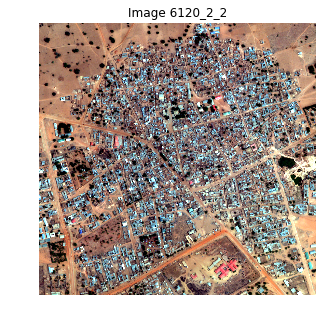

In [53]:
# RGB 3-Band image from train data.
display_img('6120_2_2')

Mask labels for image: 6120_2_2


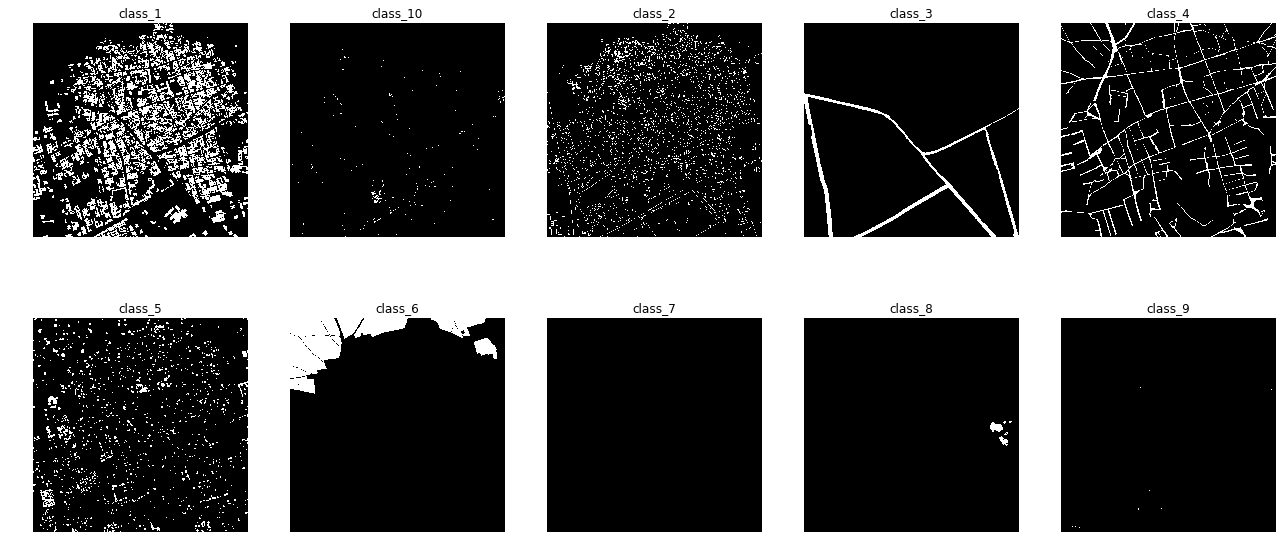

In [62]:
def display_mask(file):
    mask_label = file[21:].split('.')[0]
    img = plt.imread(file)
    plt.imshow(img, cmap='gray')
    plt.title(mask_label)
    plt.axis('off')
    
mask_files = glob.glob('data/labels/6120_2_2*.tif')

print('Mask labels for image: 6120_2_2')
for i, mask in enumerate(mask_files):
    plt.subplot(2, 5, i+1)
    display_mask(mask)
    
plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

### 2. Dilated Convolution

Dilated convolutions introduce another parameter to convolutional layers called the dilation rate. This defines a spacing between the values in a kernel. A 3x3 kernel with a dilation rate of 2 will have the same field of view as a 5x5 kernel, while only using 9 parameters. Imagine taking a 5x5 kernel and deleting every second column and row.

Dilated convolutions delivers a wider field of view at the same computational cost. 

[Source](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)


<center><img src='https://miro.medium.com/max/494/1*SVkgHoFoiMZkjy54zM_SUw.gif'></center>

In [12]:
def crp(x, amount):
  """
  Cropping layer: It crops along spatial dimensions, i.e. height and width.
  """
  return l.Cropping2D(cropping=((amount, amount), (amount, amount)))(x)

def conv_bn(x, num_filt, k=3, rate=1):
  """
  This method creates a block of three layers:
  Conv2d => BatchNormalization => ReLU
  """
  #num_filt=64
  x = l.Conv2D(num_filt, (k, k), dilation_rate=rate, padding='valid')(x)
  x = l.BatchNormalization()(x)
  x = l.core.Activation('relu')(x)
  return x

def conv1_bn(x, num_filt):
  """
  This method creates a block of three layers:
  Conv1d => BatchNormalization => ReLU
  """
  x = l.Conv2D(num_filt, (1, 1), padding='valid')(x)
  x = l.BatchNormalization()(x)
  x = l.core.Activation('relu')(x)
  return x

def conv_block(x, filts, n_conv_lay):
  """
  filts: filters for convolution.
  n_conv_lay: int, defines how much block of conv_bn layer to be created.
  
  Returns number(n_conv_lay) of conv_bn layers
  """
  for i in range(n_conv_lay):
    x = conv_bn(x, filts)
  return x

In [13]:
def dilated_block1(x, filts, rates, in_crop, n_conv_lay):
  """
  Creates convolutional layers with given dilation rates.
  crop=>conv_bn(dilation)=>conv_blok
  """
  # (Inp_L(136,136, 8), 32, [9, 3], 56, 1)
  for e, rate in enumerate(rates): #[9, 3]
    if e == 0: #1st elem
      x = crp(x, in_crop -sum(rates) -len(rates)*n_conv_lay) #(inp_L, 56 - 12 - 2*1) = (inp_L, 42) cropping
      x = conv_bn(x, filts, rate=rate) # (inp_L, 32, 9) conv=>bn=>relu
      x = conv_block(x, filts, n_conv_lay) # (inp_L, 32, 1) conv=>bn=>relu | without dilation
    else:
      x = conv_bn(x, filts, rate=rate) # (inp_L, 32, 3) conv=>bn=>relu
      x = conv_block(x, filts, n_conv_lay) # (inp_L, 32, 1) conv=>bn=>relu | without dilation
  return x

In [14]:
def crop_conv_block(x, filts, in_crop, n_conv_lay):
  ##(Input_Layer(136,136,8), 64, 56, 4)
  x = crp(x, in_crop - n_conv_lay) # (Inp_L, 56-4=52)
  for i in range(n_conv_lay): # [0,1,2,3]
    x = conv_bn(x, filts) #1. x=Crop_L, 2., x=conv_bn_L ..
  return x

In [15]:
def atr_tiny_bot(buff, out_size, num_chans, n_post_block):
  """
  Returns initial layers for the model.
  """
  filts = 32

  a_r0 = [9, 3]
  a_r1 = [5, 5]
  a_r2 = [7, 7]
  a_r3 = [6, 3]

  b_r0 = [11, 11]
  b_r1 = [9, 9]
  b_r2 = [15, 7]
  b_r3 = [19, 7]

  c_r0 = [3, 3]
  c_r1 = [5, 5]
  c_r2 = [7, 7]
  c_r3 = [5, 7]

  in_shp = 2*buff + out_size #136
  inputs = l.Input((in_shp, in_shp, num_chans)) #(136, 136, 8)

  # assumes square input images
  in_crop = (in_shp - out_size)//2 - n_post_block # (136-16)/2 -4 = 120/2 -4= 60-4 = 56

  # average pooling
  in_crop2 = (in_shp//2 - out_size)//2 - n_post_block # (136/2 - 16)/2 - 4 = (63-16)/2-4 = 47/2-4 = 23-4=19
  xconv0 = crop_conv_block(inputs, filts*2, in_crop, 4) #((136,136,8), 64, 56, 4)

  xa0 = dilated_block1(inputs, filts, a_r0, in_crop, 1) # ((136,136, 8), 32, [9, 3], 56, 1)
  xa1 = dilated_block1(inputs, filts, a_r1, in_crop, 1) # returns crp =>conv_bn(dilation1)=>conv_bn | conv_bn(dilation2)=>conv_bn
  xa2 = dilated_block1(inputs, filts, a_r2, in_crop, 1)
  xa3 = dilated_block1(inputs, filts, a_r3, in_crop, 1)

  xb0 = dilated_block1(inputs, filts, b_r0, in_crop, 1) # ((136,136, 8), 32, [11, 11], 56, 1)
  xb1 = dilated_block1(inputs, filts, b_r1, in_crop, 1) # returns crp =>conv_bn(dilation1)=>conv_bn | conv_bn(dilation2)=>conv_bn
  xb2 = dilated_block1(inputs, filts, b_r2, in_crop, 1)
  xb3 = dilated_block1(inputs, filts, b_r3, in_crop, 1)

  ave_pool = l.AveragePooling2D(pool_size=(2, 2))(inputs) # avg_pool

  xconv1 = crop_conv_block(ave_pool, filts*2, in_crop2, 4) # (avg_pool, 64, 19, 4)

  xc0 = dilated_block1(ave_pool, filts, c_r0, in_crop2, 1) # (avg_pool, 32, [3, 3], 56, 1)
  xc1 = dilated_block1(ave_pool, filts, c_r1, in_crop2, 1)
  xc2 = dilated_block1(ave_pool, filts, c_r2, in_crop2, 1)
  xc3 = dilated_block1(ave_pool, filts, c_r3, in_crop2, 1)

  xa = l.concatenate([xa0, xa1, xa2, xa3]) # concatination xa
  xb = l.concatenate([xb0, xb1, xb2, xb3]) # concatination xb
  xc = l.concatenate([xc0, xc1, xc2, xc3]) # concatination xc

  return xconv0, xconv1, xa, xb, xc, inputs

__Model Architechture__

<center>
<img src='https://github.com/danzelmo/dstl-competition/raw/master/images/model_no_activ_or_bn_small.png'>
</center>

- Network architecture is an inverted pyramid.
- Dilated convolution is used early in the network to decrease the size of the images but to retain larger receptive field.
- Different path are then combined later in the network. 
- All Conv2D layers in the above diagram  are made of `conv2d => batchnorm => relu`.

- In this notebook, single model is created for pixel level classification because of limited computational power. Seperate models for each class can further improve score but requires much computation.

In [16]:
def atr_tiny_top(buff, out_size, num_chans, n_cls):
  """
  Dilation convolutional network.
  """
  #atr_tiny_top(60, 16, 8, 9)
  filts = 128
  n_post_block = 4

  xconv0, xconv1, x1, x2, x3, inputs = atr_tiny_bot(buff, out_size, num_chans, n_post_block)
  
  xconv0 = conv_bn(xconv0, filts) #conv=>bn=>relu
  xconv0 = conv_bn(xconv0, filts) #conv=>bn=>relu

  xconv1 = conv_bn(xconv1, filts) #conv=>bn=>relu
  xconv1 = conv_bn(xconv1, filts) #conv=>bn=>relu

  x1 = conv_bn(x1, filts) #conv=>bn=>relu
  x1 = conv_bn(x1, filts) #conv=>bn=>relu

  x2 = conv_bn(x2, filts) #conv=>bn=>relu
  x2 = conv_bn(x2, filts) #conv=>bn=>relu

  x3 = conv_bn(x3, filts) #conv=>bn=>relu
  x3 = conv_bn(x3, filts) #conv=>bn=>relu

  x = l.concatenate([xconv0, xconv1, x1, x2, x3]) # concatenation
  x = conv_bn(x, filts*2) #256
  x = conv_bn(x, filts*2)

  x3 = l.Cropping2D(cropping=((2, 2), (2, 2)))(x3) #crop 2x2
  x2 = l.Cropping2D(cropping=((2, 2), (2, 2)))(x2)
  x1 = l.Cropping2D(cropping=((2, 2), (2, 2)))(x1)
  xconv0 = l.Cropping2D(cropping=((2, 2), (2, 2)))(xconv0)
  xconv1 = l.Cropping2D(cropping=((2, 2), (2, 2)))(xconv1)

  x = l.concatenate([x, xconv0, xconv1, x1, x2, x3]) # concatenation with further crop
  x = l.Dropout(0.5)(x)
  x = conv1_bn(x, 8*filts) #128*8=1024
  x = l.Dropout(0.5)(x)
  x = l.Conv2D(n_cls, (1, 1), activation='sigmoid')(x)

  model = Model(inputs=inputs, output=x)

  model.compile(optimizer=Adam(lr=0.00001),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  return model

### 3. Model Training

- Training dilated convolution model with batch_size=64, epoch=1.
- M-Band images are used for training with rescaling to 835x835. Final size for each m-band image is (835x835x8).
- 100 random patches of 136x136 from each train images are generated which totals to 2500 for all train images.
- Corresponding to the patches, 16x16 sizes of labels are taken from img masks.
- Training size => x_train: (2500, 136, 136, 8), y_train: (2500, 16, 16, 9).

- Waterclasses and vechile classes are very few in the training data therefore it seems to be a good option to merge them together into one and then classify.
- Also areas with no object classes are taken as background class. This totals to 9 classes which are as follows: 
    - Buildings
    - Manmade structures
    - Roads
    - Track
    - Trees
    - Crops
    - Clipped water classes(waterways and standing water)
    - Clipped vechile classes(small/large vechiles)
    - Background class(unclassified area)

In [7]:
def load_m(im_id):
  """
  Loads M-Band image for the given image_id.
  Returns array of size: (837, 849, 8)
  """
  return tif.imread(os.path.join(DATA_DIR, 'sixteen_band', im_id + '_M.tif')).transpose((1, 2, 0)) #(8, 837, 849)=>(837, 849, 8) | 'channels last'

def load_labels(name, size, class_num):
  """
  Loads mask image for the given image and class object.
  Returns array of size: (835, 835, 1)
  """
  return tif.imread(os.path.join(DATA_DIR, 'labels',
                                 name + '_class_' + str(class_num) + '.tif'))
  
def load_all_lab(name, size):
  """
  Loads all mask images for the given image.
  Returns array of size: (835, 835, 10)
  """
  for i in range(1, 11): #objects[1-10]
    if i == 1:
      im = load_labels(name, size, i)
      ims = np.zeros(list(im.shape[:2]) + [10]) #(835, 835, 10)
      ims[:, :, i -1] = im[:, :, 0] # (835, 835, 1) => (835, 835)
    else:
      ims[:, :, i -1] = load_labels(name, size, i)[:, :, 0]
      
  return ims

In [27]:
def get_train_patches(im, lab_im, num_sample, label_edge, buff):
  """
  Returns image patches for training.
  patch_size: 136x136
  Returns a list of 100 (patches and labels for size 136x136 and 16x16).
  """
  #((835, 835, 8), (835, 835, 9), 100, 16, 60)
  ptch = list()
  labs = list()
  im_shp = im.shape #(835, 835, 8)

  for i in range(num_sample): #100
    uly = np.random.randint(buff, im_shp[0]-buff-label_edge) #random int in range:  (60, 759)
    ulx = np.random.randint(buff, im_shp[1]-buff-label_edge) 
    
    #uly=302, ulx=288
    labs.append(lab_im[uly:uly+label_edge, ulx: ulx+label_edge, :]) #labels => 16x16
    ptch.append(im[uly-buff:uly + label_edge + buff, ulx-buff:ulx + label_edge + buff, :]) #path => 136x136
    
  return ptch, labs

In [28]:
def get_train_sample(n_samp_per_im, buff, label_size):
  """
  Returns x_train: (2500, 136, 136, 8), y_train: (2500, 16, 16, 9)
  """

  #(100, 60, 16)
  # x_train = (25*100, 2a*60+16, 2*60+16, 8) => (2500, 136, 136, 8) | sample, patch, channels
  # y_train = (25*100, 16, 16, 9) => (2500, 16, 16, 9) | sample, label, classes
  x_train = np.zeros((25*n_samp_per_im, 2*buff+label_size, 2*buff+label_size, 8), dtype=np.float32) #
  y_train = np.zeros((25*n_samp_per_im, label_size, label_size, 9), dtype=np.float32)

  for e, name in enumerate(train_names): #25 unique train images.
    im_m = load_m(name) #loading m-band: (837, 849, 8)
    im_m = ((im_m/((2.0**11)-1)) - 0.5)*2 #normalization: 
    im_m = cv2.resize(im_m, (835, 835), interpolation=0) # resizing it to (835, 835, 8)

    lab = load_all_lab(name, 835) #loading all mask labels for the current img.

    lab[:, :, 6] = lab[:, :, [6, 7]].sum(axis=-1).clip(0, 1) #clipping waterways and standing water classes.
    lab[:, :, 8] = lab[:, :, [8, 9]].sum(axis=-1).clip(0, 1) #clipping small and large vechiles.
    lab = lab[:, :, [0, 1, 2, 3, 4, 5, 6, 8]] # taking only 8 classes after clipping water and vechile classes.
    back_ground = (lab.sum(axis=-1).clip(0, 1) == 0).astype(np.uint8).reshape(list(lab.shape[:2])+[1]) # image background not in object classes. Reshape: (835, 835, 1) => (835, 835, 1)
    lab = np.concatenate((back_ground, lab), axis=-1) # classes(objects[8] + bg[1]) = 9

    patches ,labels = get_train_patches(im_m, lab, n_samp_per_im, label_size, buff) #((835, 835, 8), (835, 835, 9), 100, 16, 60)
    del im_m, lab, back_ground
    gc.collect()

    x_train[e*n_samp_per_im:(e+1)*n_samp_per_im, :, :, :] = np.array(patches, dtype=np.float32) #x_train[0:100, :, :, :] | x_train[100:200, :, :, :] | x_train[200:300]
    y_train[e*n_samp_per_im:(e+1)*n_samp_per_im, :, :, :] = np.array(labels, dtype=np.float32)

    gc.collect()
    
  return x_train, y_train

In [29]:
def augment_ims(x_train, y_train):
  """
  Image augmentation
  Transpose | Rotation
  """
  for i in range(x_train.shape[0]):
    transp = np.random.randint(2) # 0, 1
    rotation = np.random.randint(4) # 0, 1, 2, 3
    x_tmp = x_train[i, :, :, :]
    y_tmp = y_train[i, :, :, :]
    if transp == 1:
      x_train[i, :, :, :] = np.rot90(x_tmp.transpose((1, 0, 2)), k=rotation)
      y_train[i, :, :, :] = np.rot90(y_tmp.transpose((1, 0, 2)), k=rotation)
    else:
      x_train[i, :, :, :] = np.rot90(x_tmp, k=rotation)
      y_train[i, :, :, :] = np.rot90(y_tmp, k=rotation)

  return x_train, y_train

In [23]:
def jaccard(labels, preds):
  """
  Jaccard Index: Intersection over Union.
  J(A,B) = |A∩B| / |A∪B| 
         = |A∩B| / |A|+|B|-|A∩B|
  """
  tp = (labels.flatten().astype(np.int) * preds.flatten().astype(np.int)).sum()
  fp = preds.sum() - tp
  fn = labels.sum() - tp

  if (tp + fp + fn) == 0:
    return 0
  else:
    return tp / (tp + fp + fn)

In [24]:
def print_scores(preds, y_test, lab_names, include_background=True):
  all_ious = list()
  if include_background:
    const=0
  else:
    const=1
  
  for e,i in enumerate(lab_names): # [1, 2, 3, 4, 5, 6, 7, 8]
    preds1 = preds[:, :, :, e+const].flatten().astype(np.float)
    labs1 = y_test[:, :, :, e+const].flatten().astype(np.int)
    
    
    print('\n\nscores for class ' + str(i))
    print('iou for 0.4 thresh val images ',jaccard(labs1, (preds1 > 0.4)))

    iou_50 =  jaccard(labs1, (preds1 > 0.5))
    all_ious.append(iou_50)

    print('iou for 0.5 thresh val images ', iou_50)
    print('iou for 0.6 thresh val images ',jaccard(labs1, (preds1 > 0.6)))

  return all_ious

In [34]:
model = atr_tiny_top(60, 16, 8, 9)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 136, 136, 8)  0                                            
__________________________________________________________________________________________________
average_pooling2d_2 (AveragePoo (None, 68, 68, 8)    0           input_2[0][0]                    
__________________________________________________________________________________________________
cropping2d_21 (Cropping2D)      (None, 52, 52, 8)    0           input_2[0][0]                    
__________________________________________________________________________________________________
cropping2d_22 (Cropping2D)      (None, 48, 48, 8)    0           input_2[0][0]                    
__________________________________________________________________________________________________
cropping2d

/media/aaic/data/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [33]:
# del model

In [38]:
start_epoch = 0
num_epochs = 1

for j in range(0+start_epoch, start_epoch+num_epochs): #range(0+0, 0+1)
  print('\n', 'Starting epoch', j)

  x_tr, y_tr = get_train_sample(100, 60, 16) # generates random patches from 25 training images.
  x_tr, y_tr = augment_ims(x_tr, y_tr) # image augmentation : transpose | rotation

  model.fit(x_tr, y_tr, batch_size=64,
            epochs=1, verbose=1,
            shuffle=True)
  
  preds = model.predict(x_tr[range(0, x_tr.shape[0], 10), :, :, :]) #(250, 136, 136, 8)
  iou_50 = print_scores(preds, y_tr[range(0, x_tr.shape[0], 10), :, :, :], [1, 2, 3, 4, 5, 6, 7, 8], False) 

  # save model weights
  model.save_weights(os.path.join(DATA_DIR, 'weights', 'dilated_16x16'))

  del x_tr, y_tr
  gc.collect()


 Starting epoch 0
Epoch 1/1
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6700 - acc: 0.6496


scores for class 1
iou for 0.4 thresh val images  0.06222057617523346
iou for 0.5 thresh val images  0.10363871197612791
iou for 0.6 thresh val images  0.1398390342052314


scores for class 2
iou for 0.4 thresh val images  0.027495427423465564
iou for 0.5 thresh val images  0.03948857207513012
iou for 0.6 thresh val images  0.04326824254881809


scores for class 3
iou for 0.4 thresh val images  0.0017908206002137431
iou for 0.5 thresh val images  0.0013875238480661387
iou for 0.6 thresh val images  0.0


scores for class 4
iou for 0.4 thresh val images  0.0575093090608192
iou for 0.5 thresh val images  0.04697845507094062
iou for 0.6 thresh val images  0.02368692070030896


scores for class 5
iou for 0.4 thresh val images  0.1783396500700898
iou for 0.5 thresh val images  0.1914624905279111
iou for 0.6 thresh val images  0.16486518588906046


scores for class 6
iou for 

### 4. Generating Predictions 

- Generating test image labels.
- For each test images, 324 patches of size 192x192 are created for model to predict.
- Image masks are reconstructed from model predictions.
- Predicted Masks are then saved to `data/bin_masks/`.

In [6]:
# loading sample submission file 
ssubm = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))

test_names = ssubm['ImageId'].unique() # test images

In [18]:
# loading model
model = atr_tiny_top(72, 48, 8, 9)
model.load_weights('data/weights/dilated_16x16')

In [0]:
# !mkdir -p data/bin_masks/{train_16x16,test_16x16}

In [10]:
def get_patches_test(im, label_edge, buff):
  """
  Returns patches for test images of size (324, 192, 192, 8).
  """

  #((835,835,8), 48, 72)

  ptch = list()
  shp = im.shape

  num_seg_y = shp[0] // label_edge # 835/48 = 17
  num_seg_x = shp[1] // label_edge # 835/48 = 17

  im  = np.pad(im, ((buff, buff), (buff, buff), (0, 0)), mode='reflect') #  Padding: ((72, 72), (72, 72), (0, 0))

  #289
  for i in range(0, num_seg_y*label_edge, label_edge): # range(0, 17*48=816, 48)
    for j in range(0, num_seg_x*label_edge, label_edge): #range(0, 17*48, 48)

      tmp = im[i: (i+label_edge+2*buff), j: (j+label_edge+2*buff), :] # (192, 192, 8)
      ptch.append(tmp)
  
  #290
  tmp = im[-(label_edge + 2*buff):, -(label_edge + 2*buff):, :]
  ptch.append(tmp)

  #307
  for i in range(0, num_seg_y*label_edge, label_edge):
    tmp = im[i:i + label_edge + 2*buff, -(label_edge + 2*buff):, :]
    ptch.append(tmp)

  #324
  for j in range(0, num_seg_x*label_edge, label_edge):
    tmp = im[-(label_edge + 2*buff):, j:j + label_edge + 2*buff, :]
    ptch.append(tmp)
  
  return ptch

In [20]:
def reconstruct_im(preds_test, preds_mask, label_edge):
  """
  Reconstruct image from predicted patches 
  by filling in preds_mask array.
  _preds_test: (324, 48, 48, 9)
  _preds_mask: (835, 835, 9)

  return: preds_mask
  """
  shp = preds_mask.shape # (835x835x9)
  num_seg_y = shp[0] // label_edge # 835//48=17
  num_seg_x = shp[1] // label_edge
  
  print('in reconstruct_im')
  #preds_mask: 835x835x9
  #preds_test: (324, 48, 48, 9)
  
  counter = 0
  for i in range(0, num_seg_y*label_edge, label_edge): #range(0, 17*48=816, 48) will itterate to 289
    for j in range(0, num_seg_x*label_edge, label_edge):

      preds_mask[i:i + label_edge, j: j + label_edge, :] = preds_test[counter, :, :, :] #(48,48,9)
      counter += 1

  #counter=289
  preds_mask[-label_edge:, -label_edge:, :] = preds_test[counter, :, :, :]
  counter += 1

  #counter=290
  for i in range(0, num_seg_y*label_edge, label_edge): #17
    preds_mask[i:i + label_edge, -label_edge:] = preds_test[counter, :, :, :]
    counter += 1

  #counter=307
  for j in range(0, num_seg_x*label_edge, label_edge): #17
    preds_mask[-label_edge:, j:j + label_edge] = preds_test[counter, :, :, :]
    counter += 1
    
  #counter=324
  print('pred_mask rec: ', pred_mask.shape)
  return preds_mask

In [45]:
##
# train predictions

for name in train_names:
  im_m = load_m(name).astype(np.float64)

  im_m = ((im_m/((2.0**11)-1)) - 0.5)*2
  im_m = cv2.resize(im_m, (835, 835), interpolation=0)
  shp = im_m.shape

  patches = get_patches_test(im_m, 48, 72) #(324, 192, 192, 8)
  del im_m

  x_test = np.array(patches).astype(np.float32)
  del patches

  gc.collect()
  preds = model.predict(x_test) #(324, 48, 48, 9)
  gc.collect()

  pred_mask = np.zeros((shp[0], shp[1], 9)) # (835x835x9)
  pred_mask = reconstruct_im(preds, pred_mask, 48)

  tif.imsave(file=os.path.join(DATA_DIR, 'bin_masks', 'train_16x16', name+'.tif'), data=pred_mask)
  gc.collect()

  print(name)

6040_2_2
6120_2_2
6120_2_0
6090_2_0
6040_1_3
6040_1_0
6100_1_3
6010_4_2
6110_4_0
6140_3_1
6110_1_2
6100_2_3
6150_2_3
6160_2_1
6140_1_2
6110_3_1
6010_4_4
6170_2_4
6170_4_1
6170_0_4
6060_2_3
6070_2_3
6010_1_2
6040_4_4
6100_2_2


In [46]:
%%time
# test predictions

for name in test_names:
  im_m = load_m(name).astype(np.float64)

  im_m = ((im_m/((2.0**11)-1)) - 0.5)*2
  im_m = cv2.resize(im_m, (835, 835), interpolation=0)
  shp = im_m.shape

  patches = get_patches_test(im_m, 48, 72)
  del im_m

  x_test = np.array(patches).astype(np.float32)
  del patches

  gc.collect()
  preds = model.predict(x_test)
  gc.collect()

  pred_mask = np.zeros((shp[0], shp[1], 9))
  pred_mask = reconstruct_im(preds, pred_mask, 48)

  tif.imsave(file=os.path.join(DATA_DIR, 'bin_masks', 'test_16x16', name+'.tif'), data=pred_mask)
  gc.collect()

  print(name)

6120_2_4
6120_2_3
6120_2_1
6180_2_4
6180_2_1
6180_2_0
6180_2_3
6180_2_2
6180_0_3
6180_0_2
6180_0_1
6180_0_0
6180_0_4
6080_4_4
6080_4_2
6080_4_3
6080_4_0
6080_4_1
6090_4_1
6090_4_0
6090_4_3
6090_4_2
6090_4_4
6180_4_4
6180_4_3
6180_4_2
6180_4_1
6180_4_0
6160_3_2
6160_3_3
6160_3_0
6160_3_1
6160_3_4
6080_2_4
6080_2_0
6080_2_1
6080_2_2
6080_2_3
6080_0_2
6080_0_3
6080_0_0
6080_0_1
6080_0_4
6010_0_4
6010_0_1
6010_0_0
6010_0_3
6010_0_2
6010_2_3
6010_2_2
6010_2_1
6010_2_0
6010_2_4
6010_4_1
6170_3_4
6010_4_3
6170_3_1
6170_3_0
6170_3_3
6170_3_2
6170_1_3
6170_1_2
6170_1_1
6170_1_0
6170_1_4
6130_4_2
6130_4_3
6130_4_0
6130_4_1
6130_4_4
6150_3_3
6150_3_2
6150_3_1
6150_3_0
6150_3_4
6130_2_0
6130_2_1
6130_2_2
6130_2_3
6130_2_4
6130_0_4
6130_0_2
6130_0_3
6130_0_0
6130_0_1
6150_1_4
6150_1_1
6150_1_0
6150_1_3
6150_1_2
6180_3_4
6180_3_0
6180_3_1
6180_3_2
6180_3_3
6180_1_2
6180_1_3
6180_1_0
6180_1_1
6180_1_4
6010_1_4
6010_1_0
6010_1_1
6010_1_2
6010_1_3
6010_3_2
6010_3_3
6010_3_0
6010_3_1
6010_3_4
6020_0_4
6

### 5. Post processing

- Load predicted masks.
- Threshold the masks, find decent thresholds for each class, using train data and labels.
- Water and vechile classes are separately classified as follows:
    - If an image contains a waterway(like river) it must intersect two or more edges of the image, a river cannot has a source and mouth on a 1km^2area,
    - If object intersects image's edges only once and if object's area is less than threshold value(5000), object is classified as standing water otherwise it is waterway.
    - Small and large vechile are separated based on area with limit 200 and 800.
- Generated WKT, first turn masks into polygons and then polygons into wkt.
- Write each WKT to a file.

In [49]:
im_names = glob.glob(os.path.join(DATA_DIR, 'bin_masks', 'train_16x16', '*.tif')) # train prediction masks.
label_list = list()
train_pred_list = list()

for name in im_names: #25 train pred masks: (835x835x9)
  prediction = tif.imread(name)
  train_pred_list.append(prediction[:, :, 1:]) 
  shape = prediction.shape[:2]
  label_list.append(load_all_lab(name.split('/')[-1].split('.')[0], 835)) # train labels: 250

In [50]:
len(train_pred_list)

25

In [52]:
def find_thresh(masks, labels, lab_pos):
  """
  
  """
  #()
  thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8]
  best_iou = 0
  best_thresh = -1
  for i in thresh:
    for e, j in enumerate(masks):
      if e == 0:
        tmp = j[:, :, lab_pos] > i
        tmp = tmp.reshape((tmp.shape[0] * tmp.shape[1], -1))

        lab = labels[e][:, :, lab_pos]
        lab = lab.reshape((tmp.shape[0] * tmp.shape[1], -1))

      else:
          t = (j[:, :, lab_pos] > i)
          t = t.reshape(t.shape[0] * t.shape[1], -1)
          tmp = np.concatenate((tmp, t), axis=0)

          l = labels[e][:, :, lab_pos]
          l = l.reshape(t.shape[0] * t.shape[1], -1)
          lab = np.concatenate((lab, l), axis=0) 

    total_iou = jaccard(lab, tmp)

    if total_iou > best_iou:
        best_thresh = i
        best_iou = total_iou

  return best_thresh

In [53]:
thresholds = list()

for i in range(8):
  best_threshold = find_thresh(train_pred_list, label_list, i)
  thresholds.append(best_threshold)

In [54]:
thresholds

[0.75, 0.6, 0.6, 0.4, 0.5, 0.5, 0.8, 0.8]

In [4]:
# !mkdir data/submissions/subm16x16

In [58]:
#this method is based on solution posted in forum for differentiating river from standing water. 
def get_standing_river(im_mask, water_ind = -2):
    empty = np.zeros(im_mask.shape[:2])
    if im_mask[:,:,water_ind].sum() > 50000:
        return im_mask[:,:,-2], empty
    else:
        return empty, im_mask[:,:,-2]

def remove_large(train_mask, limit):
    tl = measure.regionprops(measure.label(train_mask)) #measure properties of mask
    for i in tl:
        if i.area > limit:
            c = i.coords
            for k in range(c.shape[0]):
                train_mask[c[k,0], c[k,1]] = 0
    return train_mask

def make_car_truck(vehicles):
    car = remove_large(vehicles.copy(),200)
    car = morphology.remove_small_objects(car, 12) #remove noise smaller than 12.
    
    truck = remove_large(vehicles.copy(),800)
    truck = morphology.remove_small_objects(truck, 30) #remove noise
    return car, truck

In [68]:
def mask_to_polygons(mask, epsilon=1, min_area=1.):
    """
    Converts masks to multipolygon objects.
    """
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_L1)

    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]

    if not approx_contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # need to re add in the check for type of all_polygons
        all_polygons = MultiPolygon(all_polygons)
    return all_polygons

In [69]:
# generate wkt's
def make_poly(name, mask, epsilon, min_area):
    """
    Creates a set of polygons from an image mask and scales it to submission coordinates.
    """
    shp = mask.shape
    mpoly = mask_to_polygons(mask, epsilon=epsilon, min_area=min_area)
    scaled = scale_multipolygon(name, mpoly, shp[0], shp[1])
    return scaled

In [70]:
def make_wkt(name, poly_lab_num, mask, epsilon, min_area):
    shp = mask.shape

    scaled = make_poly(name, mask, epsilon, min_area)

    wkt_tmp = wkt.dumps(scaled)
    pred = [name, poly_lab_num, wkt_tmp]
    return pred

In [71]:
def scale_multipolygon(im_name, mpoly, height, width):
    """
    Scales a multipolgon using the gridsizes provided by kaggle admins
    """
    grid_sizes = pd.read_csv(os.path.join(DATA_DIR,'grid_sizes.csv'), index_col=0)

    x_max = grid_sizes.loc[im_name, 'Xmax']
    y_min = grid_sizes.loc[im_name, 'Ymin']

    return affinity.scale(mpoly, xfact=x_max / width, yfact=y_min / height, origin=(0, 0))

In [72]:
def simple_to_wkt(threshed_masks, im_name, class_nums):
    all_preds = list()
    for e, c_num in enumerate(class_nums):
        mask = threshed_masks[:, :, e]

        mask = cv2.resize(mask.astype(np.uint8), (mask.shape[1] * 4, mask.shape[0] * 4), interpolation=0)
        tmp_wkt = make_wkt(im_name, c_num, mask, 1, 1)
        all_preds.append(tmp_wkt)
        gc.collect()

    all_preds = pd.DataFrame(all_preds, columns=['ImageId', 'ClassType', 'MultipolygonWKT'])
    all_preds = all_preds.replace(['POLYGON EMPTY', 'GEOMETRYCOLLECTION EMPTY'],
                                  ['MULTIPOLYGON EMPTY','MULTIPOLYGON EMPTY'])
    return all_preds

In [73]:
def create_submission_file(files, loc):
  
  for file in files:
    file = file.split('.')[0]
    read_path = 'data/bin_masks/test_16x16/'
    preds = tif.imread(read_path+file+'.tif')

    new_preds = np.zeros(list(preds.shape[:2])+[8])

    for i in range(8):
        new_preds[:,:,i] = preds[:,:,i+1] > thresholds[i]
        
    new_preds = new_preds.astype(np.uint8)
    preds = new_preds.copy()
    
    new_preds = np.zeros((list(preds.shape[:2])+[10]), dtype=bool)
    new_preds[:,:,:6] = preds[:,:,:6]
    river, water = get_standing_river(preds.copy())
    new_preds[:,:,6] = river
    new_preds[:,:,7] = water
    
    car, truck = make_car_truck(preds[:,:,-1])
    
    new_preds[:,:,8] = car
    new_preds[:,:,9] = truck
    
    pred_df = simple_to_wkt(new_preds, file, list(range(1,11)))
    tmp_path = loc + file + '_wkt.csv'
    pred_df.to_csv(tmp_path)
    print(file)

In [74]:
files = [f.split('.')[0] for f in os.listdir('data/bin_masks/test_16x16')]
loc = 'data/submissions/subm16x16/'

create_submission_file(files, loc)

6010_0_0
6010_0_1
6010_0_2
6010_0_3
6010_0_4
6010_1_0
6010_1_1
6010_1_2
6010_1_3
6010_1_4
6010_2_0
6010_2_1
6010_2_2
6010_2_3
6010_2_4
6010_3_0
6010_3_1


/media/aaic/data/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:132: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


6160_3_3
6160_3_4
6160_4_0
6160_4_1
6160_4_2
6160_4_3
6160_4_4
6170_0_0
6170_0_1
6170_0_2
6170_0_3
6170_1_0
6170_1_1
6170_1_2
6170_1_3
6170_1_4
6170_2_0
6170_2_1
6170_2_2
6170_2_3
6170_3_0
6170_3_1
6170_3_2
6170_3_3
6170_3_4
6170_4_0
6170_4_2
6170_4_3
6170_4_4
6180_0_0
6180_0_1
6180_0_2
6180_0_3
6180_0_4
6080_2_3
6080_2_4
6080_3_0
6080_3_1
6080_3_2
6080_3_3
6080_3_4
6080_4_0
6080_4_1
6080_4_2
6080_4_3
6080_4_4
6090_0_0
6090_0_1
6090_0_2
6090_0_3
6090_0_4
6090_1_0
6090_1_1
6090_1_2
6090_1_3
6090_1_4
6090_2_1
6090_2_2
6090_2_3
6090_2_4
6090_3_0
6090_3_1
6090_3_2
6090_3_3
6090_3_4
6090_4_0
6130_1_0
6130_1_1
6130_1_2
6130_1_3
6130_1_4
6130_2_0
6130_2_1
6130_2_2
6130_2_3
6130_2_4
6130_3_0
6130_3_1
6130_3_2
6130_3_3
6130_3_4
6130_4_0
6130_4_1
6130_4_2
6130_4_3
6130_4_4
6140_0_0
6140_0_1
6140_0_2
6140_0_3
6140_0_4
6140_1_0
6010_3_2
6020_4_3
6040_1_4
6050_0_3
6060_0_0
6060_3_4
6070_2_4
6080_2_2
6090_4_1
6100_3_4
6110_2_3
6120_1_4
6130_0_4
6140_1_1
6150_1_2
6160_3_2
6180_1_0
6180_1_1
6180_1_2
6

### 6. Submission

- Generating submission file(csv) with 429 test images which totals to 4290 rows.

In [54]:
files = glob.glob(os.path.join(DATA_DIR, 'submissions', 'subm16x16', '*.csv'))

In [77]:
dfs = list()
for file in files:
  dfs.append(pd.read_csv(file, index_col=0))

In [56]:
sample_subm = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
subm = pd.concat(dfs)

In [57]:
def make_index(sub):
  """
  Creating index key : ImageId+ClassType
  """
  sub['key'] = sub.apply(lambda x: str(x[0])+str(x[1]), axis=1)
  sub = sub.set_index('key', drop=True)
  return sub

In [102]:
sample_subm = make_index(sample_subm)
subm = make_index(subm)
subm = subm.reindex(sample_subm.index)

In [103]:
subm = subm.set_index('ImageId', drop=True) # indexing column 'ImageId'
subm.to_csv('debug_subm_16x16.csv')

In [108]:
subm1 = pd.read_csv('debug_subm_16x16.csv')
subm1 = make_index(subm1)

In [110]:
# for simplicity just remove the multipolygons with net topology errors.
subm1.loc['6100_0_22', 'MultipolygonWKT'] = 'MULTIPOLYGON EMPTY'
subm1.loc['6060_1_42', 'MultipolygonWKT'] = 'MULTIPOLYGON EMPTY'

In [113]:
subm1 = subm1.set_index('ImageId', drop=True)
subm1.to_csv('subm_16x16.csv')

#### Sample results `6120_2_3`

In [64]:
subm = pd.read_csv('subm_16x16.csv')
subm.set_index('ImageId', inplace=True)

subm.head()

,ImageId,ClassType,MultipolygonWKT
0,6120_2_4,1,MULTIPOLYGON (((0.0061676407185629 -0.00800067...
1,6120_2_4,2,MULTIPOLYGON (((0.0032542275449102 -0.00899669...
2,6120_2_4,3,MULTIPOLYGON (((0.0004507544910180 -0.00902917...
3,6120_2_4,4,MULTIPOLYGON (((0.0090810538922156 -0.00902917...
4,6120_2_4,5,MULTIPOLYGON (((0.0091250299401198 -0.00902917...


In [125]:
#generating image masks from wkt multipolygons.

base_size = 835
test_names = ['6120_2_3']
for im_name in test_names:
  for i in range(1, 11):
    polys = get_polygon_list(subm, im_name, i)
    x_max = grid_sizes.loc[im_name, 'Xmax']
    y_min = grid_sizes.loc[im_name, 'Ymin']

    plist, ilist = get_and_convert_contours(polys, (base_size, base_size), x_max, y_min)
    im_mask = plot_mask((base_size, base_size), plist, ilist)
    im_mask = im_mask.reshape((base_size, base_size, 1))

    tif.imsave(os.path.join(DATA_DIR, 'predictions', im_name + '_class_' + str(i) + '.tif'), im_mask)

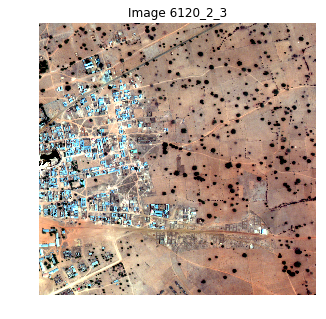

In [130]:
# RGB image: 6120_2_3
display_img('6120_2_3')

Mask labels for image: 6120_2_3


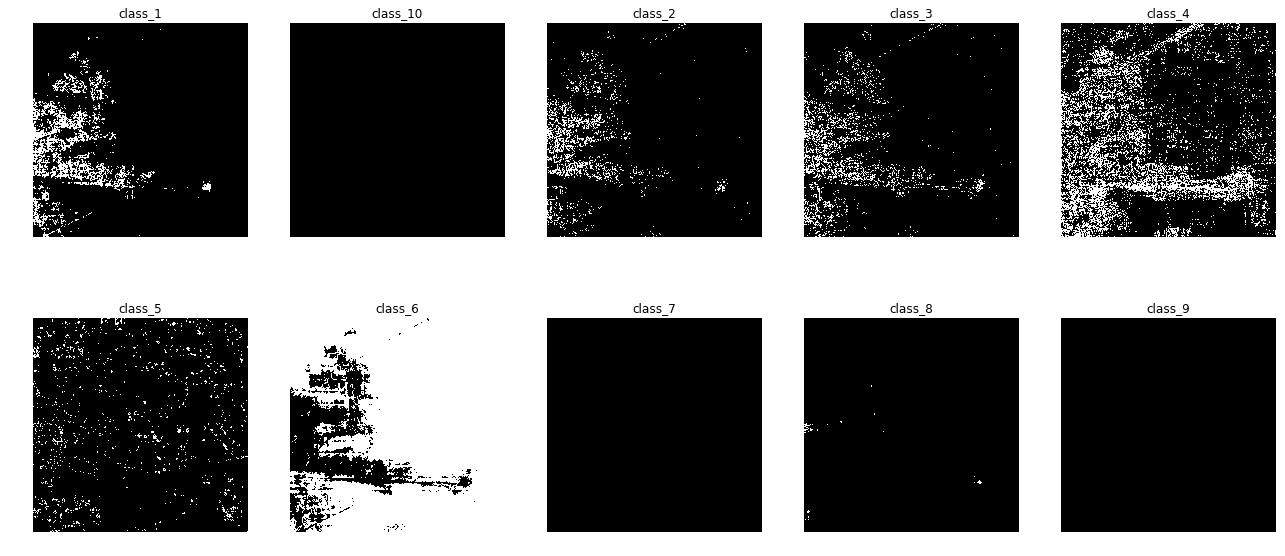

In [131]:
%matplotlib inline

def display_mask(file):
    mask_label = file[26:].split('.')[0]
    img = plt.imread(file)
    plt.imshow(img, cmap='gray')
    plt.title(mask_label)
    plt.axis('off')
    
mask_files = glob.glob('data/predictions/6120_2_3*.tif')

print('Mask labels for image: 6120_2_3')
for i, mask in enumerate(mask_files):
    plt.subplot(2, 5, i+1)
    display_mask(mask)
    
plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

## Reference
- https://github.com/danzelmo/dstl-competition 